### Question 2 CNN for CIFAR10 dataset in PyTorch

#### To be run on GPUs


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.metrics import confusion_matrix

#### 2.1 (1) Torch imports

In [2]:
# Your Code Here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

torch.__version__

'1.6.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Function to calculate size of output of final convolutional layer

In [4]:
def calc_image_size(layers,size_in,padding=0,kernel=3,stride=2,dilation=1):
    """layers: the number of maxPool operations
       size_in: height or width of image
       """
    for _ in range(layers):
        size_in = np.floor(((size_in + 2*padding - dilation*(kernel-1)-1)/stride)+1)
        #print(size_in)
    return int(size_in)

#### 2.2 (2) Download and transform Cifar10 data from torchvision

* The Cifar10 dataset has 3 color channels
* Show the shape of the training data and the type the test dataset

In [5]:

transformer_train = torchvision.transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),])

# Your Code Here
train_data = torchvision.datasets.CIFAR10(root=".", train=True, transform=transformer_train, download=True)
test_data = torchvision.datasets.CIFAR10(root=".", train=False, transform=transforms.ToTensor(), download=True)
train_data.data.shape, test_data.data.dtype


Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), dtype('uint8'))

#### 2.3 (1) Create train and test loaders using mini-batch size of 64

In [7]:
# Your Code Here
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


#### 2.4 (8) Create CNN Model Class

* Create 2 blocks, conv1 and conv2 of convolutional layers using the Sequential class for each block.
    - Inside the block should be  a two conv2d classes with 32 output channels, two ReLU and two Batch Normalizations  
    
* Create two linear layers, linear1 and linear2, linear1 should have an output of 1024 channels  
* In the forward function wrap linear1 in a ReLU and add a dropout layer after it  

* Hint:  Use calc_image_size  to help determining the size of the flattened image
    

In [9]:
# Call calc_image_size

# Your Code Here
for i in range(4):
    image_size = calc_image_size(i+1, 32)
    print(image_size)

15
7
3
1


In [10]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the conv layers, flatten and linear layers
    
    # Your Code Here
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.maxPool1 = nn.MaxPool2d((2,2))
    self.maxPool2 = nn.MaxPool2d((2,2))
    self.linear1 = nn.Linear(64 * 8 * 8, 1024)
    self.linear2 = nn.Linear(1024, K)
    
    self.flatten = nn.Flatten()
    
  def forward(self, x):
    # Your Code Here
    # print(f"{'Input:':<15} {x.shape}")
    z = self.conv1(x)
    # print(f"{'Conv1 done:':<15} {z.shape}")
    z = self.maxPool1(z)
    # print(f"{'MP1 done:':<15} {z.shape}")
    z = self.conv2(z)
    # print(f"{'Conv2 done:':<15} {z.shape}")
    z = self.maxPool2(z)
    # print(f"{'MP2 done:':<15} {z.shape}")
    z = self.flatten(z)
    # print(f"{'Flatten done:':<15} {z.shape}")
    z = nn.ReLU()(self.linear1(z))
    # print(f"{'Linear1 done:':<15} {z.shape}")
    z = nn.Dropout(0.2)(z)
    # print(f"{'Dropout done:':<15} {z.shape}")
    z = self.linear2(z)
    # print(f"{'Linear2 done:':<15} {z.shape}")
    return z
    

#### 2.5 (2) Instantiate the model and display a torchsummary model summary

In [11]:
# Your Code Here
K = len(set(train_data.targets))
# print(f"There are {K} classes to target")
model = CNN(K)
model.to(device)
summary(model, (3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          128
|    └─ReLU: 2-2                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 32, 32, 32]          64
|    └─Conv2d: 2-4                       [-1, 32, 32, 32]          1,056
|    └─ReLU: 2-5                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-6                  [-1, 32, 32, 32]          64
├─MaxPool2d: 1-2                         [-1, 32, 16, 16]          --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-7                       [-1, 64, 16, 16]          2,112
|    └─ReLU: 2-8                         [-1, 64, 16, 16]          --
|    └─BatchNorm2d: 2-9                  [-1, 64, 16, 16]          128
|    └─Conv2d: 2-10                      [-1, 64, 16, 16]          4,160
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          128
|    └─ReLU: 2-2                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 32, 32, 32]          64
|    └─Conv2d: 2-4                       [-1, 32, 32, 32]          1,056
|    └─ReLU: 2-5                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-6                  [-1, 32, 32, 32]          64
├─MaxPool2d: 1-2                         [-1, 32, 16, 16]          --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-7                       [-1, 64, 16, 16]          2,112
|    └─ReLU: 2-8                         [-1, 64, 16, 16]          --
|    └─BatchNorm2d: 2-9                  [-1, 64, 16, 16]          128
|    └─Conv2d: 2-10                      [-1, 64, 16, 16]          4,160
|   

#### 2.6 (1) Use Cross Entropy Loss and Adam optimizer with learning rate of 0.001

In [13]:
# Your Code Here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#### 2.7 (5) Code training loop for 20 epochs

* Calculate both training and test loss
* Save training loss and test loss for plotting
* Print training loss and test loss at end of every epoch


In [14]:
# Your Code Here
epochs = 30
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for e in range(epochs):
  t0 = datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  
  train_loss = np.mean(train_loss)

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[e] = train_loss
  test_losses[e] = test_loss

  dt = datetime.now() - t0
  print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


Epoch 1/30, Train Loss: 1.5445, Test Loss: 1.3535, Duration: 0:05:02.713523
Epoch 2/30, Train Loss: 1.3660, Test Loss: 1.3012, Duration: 0:04:11.194239
Epoch 3/30, Train Loss: 1.2973, Test Loss: 1.2639, Duration: 0:04:53.969247
Epoch 4/30, Train Loss: 1.2458, Test Loss: 1.2304, Duration: 0:05:07.592726
Epoch 5/30, Train Loss: 1.2027, Test Loss: 1.1982, Duration: 0:04:07.666613
Epoch 6/30, Train Loss: 1.1710, Test Loss: 1.1619, Duration: 0:04:05.648178
Epoch 7/30, Train Loss: 1.1416, Test Loss: 1.1568, Duration: 0:04:05.330066
Epoch 8/30, Train Loss: 1.1214, Test Loss: 1.1693, Duration: 0:04:04.701505
Epoch 9/30, Train Loss: 1.0891, Test Loss: 1.1279, Duration: 0:04:05.956052
Epoch 10/30, Train Loss: 1.0679, Test Loss: 1.1210, Duration: 0:04:06.952668
Epoch 11/30, Train Loss: 1.0512, Test Loss: 1.0938, Duration: 0:04:03.212962
Epoch 12/30, Train Loss: 1.0299, Test Loss: 1.1003, Duration: 0:04:04.680947
Epoch 13/30, Train Loss: 1.0150, Test Loss: 1.0758, Duration: 0:04:06.591955
Epoch 14

#### 2.8 (1) Plot the train and test loss

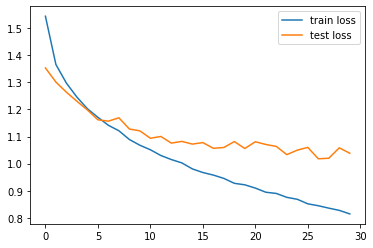

In [15]:
# Your Code Here

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### 2.9 (4 ) Predict the test data and display  results in a confusion matrix. Print the accuracy.

In [16]:
# Your Code Here
x_test = test_data.data
y_test = test_data.targets
pred_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  pred_test = np.concatenate((pred_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, pred_test)
print(cm)

print(f"Accuracy = {np.trace(cm)/np.sum(cm):.2%}")


[[643  37  62  16   8  10  17  20 138  49]
 [ 19 784   9  10   1   8   9   5  24 131]
 [ 42  11 595  76  70  56  82  43  10  15]
 [ 10  24  81 490  43 170  96  32  20  34]
 [ 25   9 155  43 554  35  98  64  13   4]
 [ 14  12  71 176  40 553  41  60  16  17]
 [  9  15  46  49  71  24 755  18   7   6]
 [ 20  11  52  46  51  49  22 691  10  48]
 [ 45  50  21  12   7  11  12  15 781  46]
 [ 28 135  12  16   3   6   5  13  36 746]]
Accuracy = 65.92%
